## 1st-level analysis (RED Go/No-go)

Adapted from Mengya's Script:

In this example, we will take the preprocessed output from the fMRIPrep and run for each subject a 1st-level analysis. For this we need to do the following steps:

0. Smooth the normalized result as fmriprep doesn't do this step
1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts
5. Plot T- and beta-images


**Before you start**
Some participants have the same run twice (due to restart of the run), make sure to delete duplicates before run analysis

## Imports

First, we need to import all the modules we later want to use.

In [10]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import json
import numpy as np
from nipype.interfaces.spm import Smooth, Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype.pipeline.engine import MapNode
from nipype import Workflow, Node
# MATLAB - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('U:/spm12')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [11]:
# Set directories
bids_dir = '/imaging/su01/RED/bids'
experiment_dir = '/imaging/su01/RED/bids/derivatives/fmriprep-1.5.0/fmriprep'
output_dir = '/imaging/su01/RED/1stlevel_output'
working_dir = '/imaging/su01/RED/1stlevel_workingdir'

###sub02 didn't have correct trials for most runs discard from analysis 
# list of subject identifiers
subject_list = ['005']

# TR of functional images
with open('/imaging/su01/RED/bids/sub-005/func/sub-005_task-task_bold.json', 'rt') as fp:
    task_info = json.load(fp)                                                 
TR = task_info['RepetitionTime']

# Smoothing kernel to use
fwhm = [6]

## Specify first level analysis pipeline & Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [12]:
# Apply spatial smoothing first since fmriprep doesn't do this step
smoothing = Node(Smooth(fwhm= fwhm*3),
                name="smoothing")

## Now implement the nodes

#unzip nii.gz files
gunzip_con = MapNode(Gunzip(), name="gunzip_con", iterfield=['in_file'])

# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

## Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. 

We have 8 conditions: 4 Go and 4 No-Go
- Sad Go; Sad NoGo
- Neutral Go; Neutral NoGo
- Happy Go; Happy NoGo
- Control Go; Control NoGo (scrambled faces)

These blocks are shown twice each for a total of 16 blocks
(In total though we have each emotion shown 4 times regardless of go/no-go type)

Main Effects
- Emotion
- Cognition (Response Inhibition)

To begin let's just compare all NoGo to Go blocks

#### From Mengya's script
With multiple regressors need to be careful with the rank efficiency of the model (should be full ranked) - 
check with function np.linalg.matrix_rank(design_matrix)


In [13]:
# Condition names
# Nipype has this idiotic thing where if you specify parametric modulators
# the interaction term created is of format  "main_regressor_namexpmod_name^1"
condition_names = ['s_n', 's_g', 'n_n', 'n_g', 'h_n', 'h_g', 'c_n', 'c_g']

# Contrasts
cont01 = ['NoGo > Go', 'T', condition_names, [0.25, -0.25, 0.25, -0.25, 0.25, -0.25, 0.25, -0.25] ]
# cont02 = ['target_difficulty', 'T', condition_names, [0,0, 0, 1, 0]]
# cont03 = ['target_notarget_difficulty', 'T', condition_names, [0,0, -1, 1, 0]]
# cont04 = ['notarget_difficulty', 'T', condition_names, [0,0, 1,0, 0]]
# cont05 = ['target>baseline', 'T', condition_names, [0, 1, 0,0,0] ]
# cont06 = ['notarget>baseline', 'T', condition_names, [1, 0, 0,0,0] ]
#
# cont07 = ['difficulty',     'F', [cont02, cont04]]
# cont08 = ['task>baseline',   'F', [cont05, cont06]]


contrast_list = [cont01]

In [8]:
# Try importing a mat file
# import pandas as pd
# from scipy.io import loadmat
# import os
#
# os.getcwd()
# test_mat = loadmat('/Users/stepheniuh/ownCloud/PhD/RED/Go-NoGo Data/GNG Task Data/sub-005_events.mat')
# test_mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Dec 14 13:14:37 2020',
 '__version__': '1.0',
 '__globals__': [],
 'conditions': array([[array(['s_n'], dtype='<U3'), array(['s_g'], dtype='<U3'),
         array(['n_n'], dtype='<U3'), array(['n_g'], dtype='<U3'),
         array(['h_n'], dtype='<U3'), array(['h_g'], dtype='<U3'),
         array(['c_n'], dtype='<U3'), array(['c_g'], dtype='<U3')]],
       dtype=object),
 'durations': array([[array([[60, 60]], dtype=uint8), array([[60, 60]], dtype=uint8),
         array([[60, 60]], dtype=uint8), array([[60, 60]], dtype=uint8),
         array([[60, 60]], dtype=uint8), array([[60, 60]], dtype=uint8),
         array([[60, 60]], dtype=uint8), array([[60, 60]], dtype=uint8)]],
       dtype=object),
 'onsets': array([[array([[208.21623888],
        [689.43217514]]),
         array([[140.48299041],
        [960.59830986]]),
         array([[410.43252292],
        [824.71524449]]),
         array([[343.23273295],
        [55

## Specify GLM model
Next step is to get info such as stimuli onset, duration, & other regressors into the GLM model.

This is where the helper function comes into play:
helper function ``subjectinfo``: grab run information from tsv file to create regressors


In [16]:
# For guidance, look at events file that was created fro events2tsv script
# !cat bids_dir + '/sub-005/func/sub-005_events.tsv'

# look at it as dataframe
import pandas as pd
trialinfo = pd.read_table(bids_dir + '/sub-005/func/sub-005_events.tsv')
trialinfo

,conditions,onset,duration,trial_type,emotion
0,c_n,1.366574,60,nogo,control
1,h_n,70.683158,60,nogo,happy
2,s_g,140.482990,60,go,sad
3,s_n,208.216239,60,nogo,sad
4,h_g,276.066159,60,go,happy
5,n_g,343.232733,60,go,neutral
6,n_n,410.432523,60,nogo,neutral
7,c_g,477.832376,60,go,control
8,n_g,554.548941,60,go,neutral
9,c_n,622.398821,60,nogo,control


In [20]:
# Separate onsets by condition
for group in trialinfo.groupby('trial_type'):
    print(group)
    print("")

('go',    conditions        onset  duration trial_type  emotion
2         s_g   140.482990        60         go      sad
4         h_g   276.066159        60         go    happy
5         n_g   343.232733        60         go  neutral
7         c_g   477.832376        60         go  control
8         n_g   554.548941        60         go  neutral
13        h_g   893.265055        60         go    happy
14        s_g   960.598310        60         go      sad
15        c_g  1028.248224        60         go  control)

('nogo',    conditions       onset  duration trial_type  emotion
0         c_n    1.366574        60       nogo  control
1         h_n   70.683158        60       nogo    happy
3         s_n  208.216239        60       nogo      sad
6         n_n  410.432523        60       nogo  neutral
9         c_n  622.398821        60       nogo  control
10        s_n  689.432175        60       nogo      sad
11        h_n  756.848661        60       nogo    happy
12        n_n  824.71

In [ ]:
# Incorporate above info in the helper function "subjectinfo"

def subjectinfo(subject_id):
    
    import glob
    import pandas as pd
    import numpy as np
    from nipype.interfaces.base import Bunch
    
    #Grab event files
    pattern = bids_dir + '/sub-%s/func/sub-%s*_events.tsv' % (subject_id, subject_id)
    path = sorted(glob.glob(pattern))
    ##print(path)
    assert len(path)>0, f"could not find subject for {pattern}"
        
    #Grab confound files
    pattern_confound = experiment_dir + '/sub-%s/func/sub-%s*_regressors.tsv' % (subject_id, subject_id)
    path_confound = sorted(glob.glob(pattern_confound))
    ##print (path_confound)
    
    subject_info=[]
    for i in range(len(path)):
        trialinfo = pd.read_table(path[i])
        conditions = []
        onsets = []
        durations = []
        
        #append target present/absent conditions into Bunch object
        for group in trialinfo.groupby('trial_type'):
            conditions.append(group[0])
            onsets.append(np.round(group[1].onset.values,0).tolist())
            durations.append(np.round(group[1].duration.values,0).tolist())
        
        #below from Mengya's script but maybe group by emotion later
        #append correct/incorrect conditions into Bunch object
        #In case some runs subjects didn't make mistakes, assign a onset that's beyond the period of the run
#         for group in trialinfo.groupby('correct'):
#             if group[0]==0:
#                 conditions.append('incorrect')
#                 onsets.append(np.round(group[1].fixation_onset.values, 0).tolist())
#                 durations.append(np.round(group[1].duration.values,0).tolist())
#         if 'incorrect' not in conditions:
#             conditions.append('incorrect')#incase of no trial type exist, create a pseudo event 
#             onsets.append([12000.0])
#             durations.append([10.0])
        
        #confound parameters
        confounds =pd.read_csv(path_confound[i], sep="\t", na_values="n/a")
    
        subject_info.append(Bunch(conditions=conditions,
                              onsets=onsets,
                              durations=durations,
                              pmod=[Bunch(name=['difficulty'],poly=[1],
                                         param=[difficulty[0]]), 
                                    Bunch(name=['difficulty'],poly=[1],
                                         param=[difficulty[1]]),None],
                              #Include motion regressors
                              regressors = [#list(confounds.FramewiseDisplacement.fillna(0)),
                                             list(confounds.X),
                                            list(confounds.Y),
                                            list(confounds.Z),
                                            list(confounds.RotX),
                                            list(confounds.RotY),
                                            list(confounds.RotZ)
                               ],
                              regresssor_names=[#'FramewiseDisplacement',
                                                'X',
                                                'Y',
                                                'Z',
                                                'RotX',
                                                'RotY',
                                                'RotZ']
                               
                              #amplitudes=None,
                              #tmod=None,
                             ))

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [13]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)
                        ]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': 'fmriprep/sub-'+'{subject_id}/func/*vs*_preproc.nii.gz'}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'vs'


# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]

datasink.inputs.substitutions = substitutions



NameError: name 'contrast_list' is not defined

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [14]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (selectfiles, gunzip_con, [('func', 'in_file')]),
                    (gunzip_con, smoothing, [('out_file',
                                             'in_files')]),
                    (smoothing, modelspec, [('smoothed_files',
                                            'functional_runs')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])



NameError: name 'infosource' is not defined

## Visualize the workflow

It always helps to visualize your workflow.

In [63]:
# # Create 1st-level analysis output graph
# l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# # Visualize the graph
# from IPython.display import Image
# Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [ ]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 16})

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should have nine contrast images (``con_*.nii`` for T-contrasts and ``ess_*.nii`` for T-contrasts) and nine statistic images (``spmT_*.nii`` and ``spmF_*.nii``) for every subject and smoothing kernel.

In [282]:
!tree output_1stlevel_vs/1stLevel/

output_1stlevel_vs/1stLevel/
├── sub-01
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── con_0004.nii
│   ├── ess_0005.nii
│   ├── spmF_0005.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   └── spmT_0004.nii
├── sub-02
│   ├── con_0001.nii
│   ├── SPM.mat
│   └── spmT_0001.nii
├── sub-03
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── con_0004.nii
│   ├── ess_0005.nii
│   ├── spmF_0005.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   └── spmT_0004.nii
├── sub-04
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── con_0004.nii
│   ├── ess_0005.nii
│   ├── spmF_0005.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   └── spmT_0004.nii
├── sub-05
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── con_0004.nii
│   ├── ess_0005.nii
│   ├── spmF_0005.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii

## Visualize results

Let's look at the contrasts of one subject that we've just computed. First, let's see what the difference of smoothing is for the contrast **`average`**

In [6]:
from nilearn import plotting
sub = '01'
anatimg = '/imaging/mz01/fmriprep/sub-%s/anat/sub-%s_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz' % (sub,sub)

In [ ]:
plotting.plot_stat_map(
    '/imaging/mz01/output_1stlevel_vs/1stLevel/sub-%s/spmT_0001.nii'%(sub), title='average_sub%s'%sub,
    bg_img=anatimg, threshold=3, display_mode='ortho');

In [ ]:
view = plotting.view_img('output_1stlevel_vs/1stLevel/sub-%s/spmT_0001.nii'%(sub), bg_img = anatimg,
                         title='Tmap_targetvsnotargetsub%s'%sub, threshold=3)
view

Interactive image

In [1]:
view = plotting.view_img('output_1stlevel_vs/1stLevel/sub-%s/spmT_0002.nii'%(sub), bg_img = anatimg,
                         title='Tmap_targetxdifficulty_effect_sub%s'%sub, cut_coords=(-14,-67,51),threshold=3)
view

NameError: name 'plotting' is not defined

In [ ]:
view = plotting.view_img('output_1stlevel_vs/1stLevel/sub-%s/spmT_0005.nii'%(sub), bg_img = anatimg,
                         title='Tmap_targetvsnotarget_diff_sub%s'%sub, cut_coords=(-14,-67,51),threshold=3)
view


# Visualize design matrix


In [104]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

First, let's look at the 1st-level Design Matrix of subject 01, to verify that everything is as it should be.


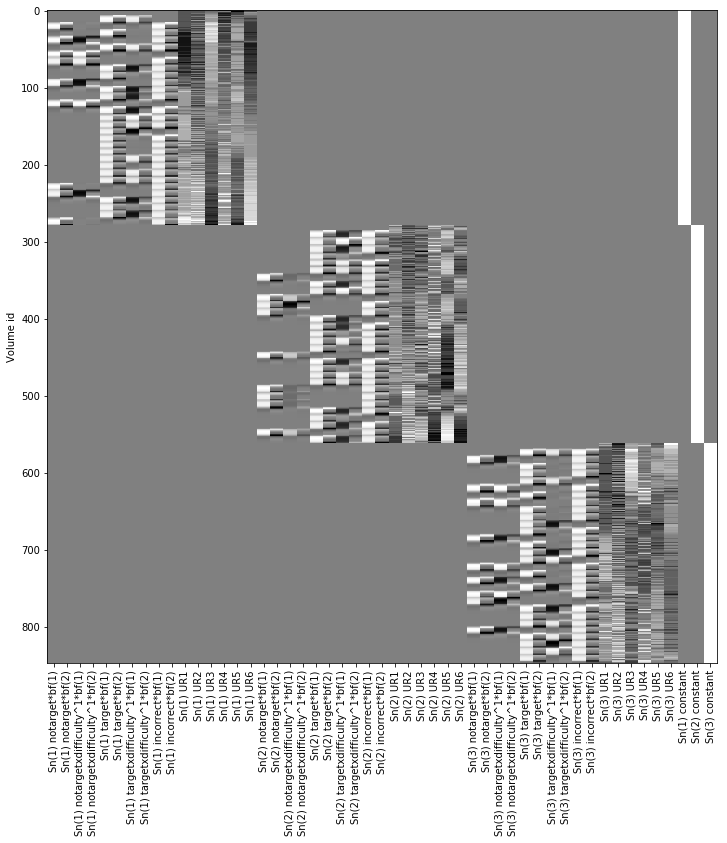

In [106]:
from scipy.io import loadmat

# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat('output_1stlevel_vs/1stLevel/sub-%s/SPM.mat'%sub,
                 struct_as_record=False)
#access the matrix and name of regressors
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

#Now before we can plot it, we just need to normalize the desing matrix in such a way, 
#that each column has a maximum amplitude of 1. This is just for visualization purposes, 
#otherwise the rotation parameters with their rather small values will not show up in the figure.
normed_design = designMatrix / np.abs(designMatrix).max(axis=0)
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);